### Load the datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import csv
import IPython
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import IPython.display
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
regions = ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
           'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
           'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia',
           'Sardegna', 'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta", 'Veneto']

In [97]:
# File name
#file_path = "../Data/"
file_path = '/content/drive/Othercomputers/Laptop/homework3/Data/'

train_df = {}
val_df = {}

# Load data
for reg in regions:

  train_df[reg] = pd.read_csv(file_path + 'Train/' + str(reg) + '.csv', 
                                   parse_dates = True)
  val_df[reg] = pd.read_csv(file_path + 'Validation/' + str(reg) + '.csv', 
                                   parse_dates = True)
  
  # Put date as index
  train_df[reg].set_index('data', inplace=True)
  val_df[reg].set_index('data', inplace=True)


### Class WindowGenerator

Il resto di questa sezione definisce una classe WindowGenerator . Questa classe può:

 - Gestire gli indici e gli offset
 - Divide le finestre di funzionalità in coppie (features, labels) .
 - Traccia il contenuto delle finestre risultanti.
 - Genera in modo efficiente batch di queste finestre dai dati di addestramento, valutazione e test

In [98]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    '''
      Dato un elenco di input consecutivi, li converte in una finestra di input
       e in una finestra di etichette.
    '''
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
  
  def plot(self, model=None, plot_col='INSERIRE NOME COL', max_subplots=1):
    inputs, labels = self.example
    plt.figure(figsize=(12, 4))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()
 
  def make_dataset(self, data):
    '''
      Prende una serie temporale DataFrame e la convertirà in un tf.data.Dataset
       di coppie (input_window, label_window)
    '''
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
  

### Modello a più fasi Lombardia

In una previsione a più fasi, il modello deve imparare a prevedere una serie di valori futuri. Pertanto, a differenza di un modello a fase singola, in cui è previsto un solo punto futuro, un modello a più fasi prevede una sequenza di valori futuri.

Ci sono due approcci approssimativi a questo:

 - Pronostici a colpo singolo in cui l'intera serie temporale viene prevista contemporaneamente.
 - Previsioni autoregressive in cui il modello effettua solo previsioni a passo singolo e il suo output viene restituito come input.

In [99]:
train_reg = train_df['Lombardia']
val_reg = val_df['Lombardia']

In [100]:
len_input = np.shape(train_reg)[0]

In [101]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=len_input-OUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_reg, 
                               val_df=val_reg)

In [102]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

In [103]:
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [104]:
multi_window.train.element_spec

(TensorSpec(shape=(None, 83, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 7, 4), dtype=tf.float32, name=None))

In [105]:
example_window = tf.stack([np.array(train_reg)])

example_inputs, example_labels = multi_window.split_window(example_window)

#multi_window.example = example_inputs, example_labels

Total window size: 90
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
Label indices: [83 84 85 86 87 88 89]
Label column name(s): None

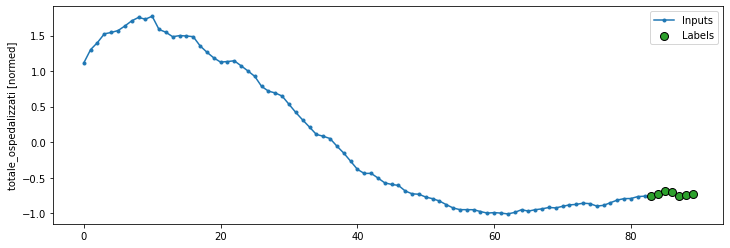

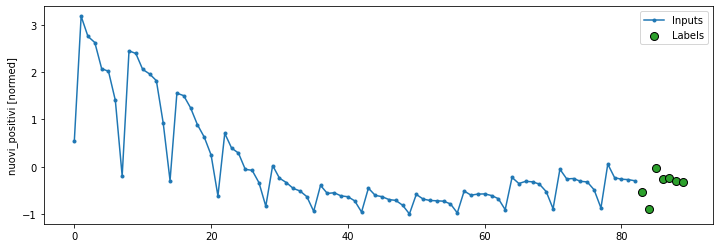

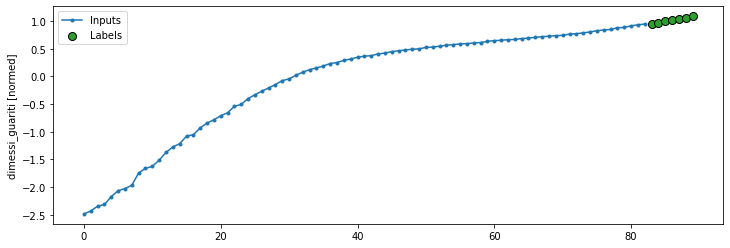

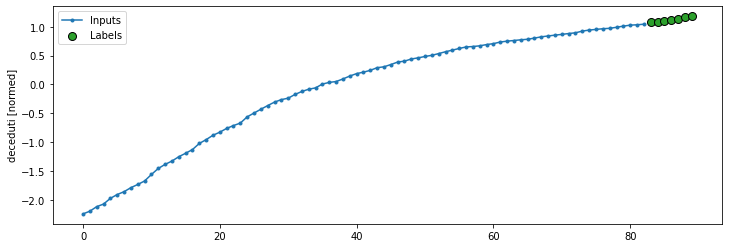

In [106]:
multi_window.plot(plot_col = 'totale_ospedalizzati' )
multi_window.plot(plot_col = 'nuovi_positivi' )
multi_window.plot(plot_col = 'dimessi_guariti' )
multi_window.plot(plot_col = 'deceduti' )

multi_window

### Modello autoregressivo

In alcuni casi può essere utile che il modello scomponga la previsione in singoli passaggi temporali. Quindi, l'output di ciascun modello può essere reimmesso in se stesso ad ogni passaggio e le previsioni possono essere fatte condizionate dal precedente.

In alcuni casi può essere utile che il modello scomponga questa previsione in singoli passaggi temporali. Quindi, l'output di ciascun modello può essere reimmesso in se stesso ad ogni passaggio e le previsioni possono essere fatte condizionate dal precedente

In [141]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dropout = tf.keras.layers.Dropout(0.2)
    self.dense = tf.keras.layers.Dense(num_features)
  
  def warmup(self, inputs):
    '''
      Inizializza lo stato interno in base agli input. 
      Una volta addestrato, questo stato acquisirà le parti rilevanti della cronologia di input
      Restituisce una singola previsione del passo temporale e lo stato interno LSTM
    '''
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)
    
    x = self.dropout(x)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

  def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
      # Use the last prediction as input.
      x = prediction
      # Execute one lstm step.
      x, state = self.lstm_cell(x, states=state,
                                training=training)
      # Convert the lstm output to a prediction.
      prediction = self.dense(x)
      # Add the prediction to the output.
      predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

In [156]:
num_features = 4
feedback_model = FeedBack(units=8, out_steps=OUT_STEPS)  #32

In [157]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([1, 4])

In [144]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (1, 7, 4)


In [158]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [159]:
history = compile_and_fit(feedback_model, multi_window)

#multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
#multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.7658 - mean_absolute_error: 0.8204
Epoch 2/200
1/1 [==============================] - 0s 85ms/step - loss: 0.7642 - mean_absolute_error: 0.8186
Epoch 3/200
1/1 [==============================] - 0s 100ms/step - loss: 0.7390 - mean_absolute_error: 0.8028
Epoch 4/200
1/1 [==============================] - 0s 90ms/step - loss: 0.7279 - mean_absolute_error: 0.7967
Epoch 5/200
1/1 [==============================] - 0s 95ms/step - loss: 0.7320 - mean_absolute_error: 0.8003
Epoch 6/200
1/1 [==============================] - 0s 94ms/step - loss: 0.7134 - mean_absolute_error: 0.7884
Epoch 7/200
1/1 [==============================] - 0s 93ms/step - loss: 0.7021 - mean_absolute_error: 0.7830
Epoch 8/200
1/1 [==============================] - 0s 90ms/step - loss: 0.7323 - mean_absolute_error: 0.7995
Epoch 9/200
1/1 [==============================] - 0s 90ms/step - loss: 0.6871 - mean_absolute_error: 0.7727
Epoch 10/200
1/1 [==

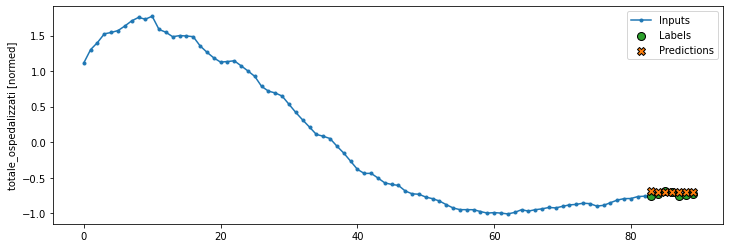

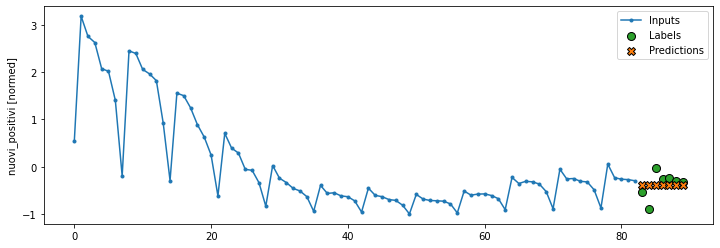

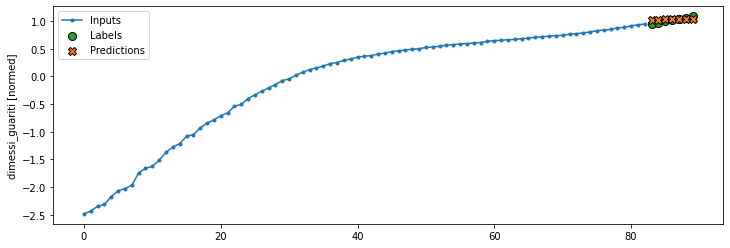

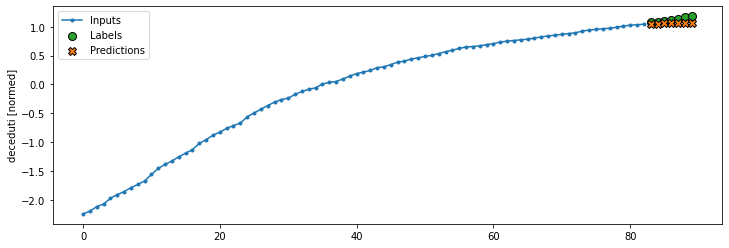

In [160]:
multi_window.plot(feedback_model, plot_col = 'totale_ospedalizzati' )
multi_window.plot(feedback_model, plot_col = 'nuovi_positivi' )
multi_window.plot(feedback_model, plot_col = 'dimessi_guariti' )
multi_window.plot(feedback_model, plot_col = 'deceduti' )